# Challenge III

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl

In [63]:
df = pd.read_excel(r'C:\Users\xelin\OneDrive\Desktop\Graduate School\3rd trimester\capstone\scrap\2022-04-13 RN Scrap Data w Cost.xlsx', engine = 'openpyxl')
df.rename({'Date (1/1/2015-4/8/2022)':'date'}, axis = 1, inplace = True)
df.set_index('date', inplace = True)

In [37]:
df.columns

Index(['Reject Notice', 'Part Number', 'Qty', 'Unit Price'], dtype='object')

In [38]:
year_grouped_sum = df[['Qty', 'Part Number']].groupby(['Part Number',pd.Grouper(freq='Y')]).sum().reset_index()
year_grouped_count = df[['Qty', 'Part Number']].groupby(['Part Number',pd.Grouper(freq='Y')]).count().reset_index()

# TODO: add this

In [39]:
df_costs = df.groupby('Part Number')[['Unit Price']].first()
df_costs

,Unit Price
Part Number,
022347JAY,98.00
0270405JAY,178.00
0270469JAY,312.00
1001599-1,16.40
1001599-6,47.70
...,...
SV_2288543,180.88
SV_3241735,102.82
SV_3241771,302.01


## Collect Last Scraping date by Part Number

In [40]:
df_last_date = df.reset_index().sort_values(by = ['date'], ascending = True).groupby('Part Number').last()[['date']]


df_last_date

,date
Part Number,
022347JAY,2022-01-18
0270405JAY,2015-01-23
0270469JAY,2022-01-18
1001599-1,2015-01-07
1001599-6,2020-06-18
...,...
SV_2288543,2018-06-12
SV_3241735,2021-10-14
SV_3241771,2022-02-07


In [41]:
import datetime

df_last_date['diff_years'] = df_last_date['date'].apply(lambda x: (pd.to_datetime(datetime.datetime.now()) - x).days//365)

df_last_date

,date,diff_years
Part Number,,
022347JAY,2022-01-18,0
0270405JAY,2015-01-23,7
0270469JAY,2022-01-18,0
1001599-1,2015-01-07,7
1001599-6,2020-06-18,1
...,...,...
SV_2288543,2018-06-12,3
SV_3241735,2021-10-14,0
SV_3241771,2022-02-07,0


## Pivoting

In [42]:
df_by_sum = year_grouped_sum.pivot(index='Part Number', columns='date', values='Qty').fillna(0)

df_by_count = year_grouped_count.pivot(index='Part Number', columns='date', values='Qty').fillna(0).reset_index()

In [43]:
df_by_sum = df_by_sum.merge(df_costs, left_index= True, right_index= True)

In [44]:
df_by_sum.iloc[:,1].values * df_by_sum.iloc[:,-1].values

array([0., 0., 0., ..., 0., 0., 0.])

In [45]:
df_by_count.columns = np.array(['Part Number', '2015', '2016',
       '2017', '2018', '2019',
       '2020', '2021', '2022'])

In [46]:
df_by_count['scraped_2022'] = df_by_count['2022'].apply(lambda x: True if x > 0 else False)
df_by_count['scraped_2021'] = df_by_count['2021'].apply(lambda x: True if x > 0 else False)
df_by_count['scraped_2020'] = df_by_count['2020'].apply(lambda x: True if x > 0 else False)
df_by_count['scraped_2019'] = df_by_count['2019'].apply(lambda x: True if x > 0 else False)

In [47]:
df_counts = df_by_count[['Part Number','scraped_2022','scraped_2021','scraped_2020','scraped_2019']].copy()

In [48]:
df_counts.set_index('Part Number', inplace = True)

In [49]:
df_counts.sum()

scraped_2022    171
scraped_2021    672
scraped_2020    660
scraped_2019    797
dtype: int64

In [50]:
df_counts['scraped_2022_2021'] = df_counts.scraped_2021 & df_counts.scraped_2022
df_counts['scraped_2022_2021_2020'] = df_counts.scraped_2020 & df_counts.scraped_2021 & df_counts.scraped_2022
df_counts['scraped_2022_2021_2020_2019'] = df_counts.scraped_2019 & df_counts.scraped_2020 & df_counts.scraped_2021 & df_counts.scraped_2022
df_counts['No_scraped_last_2_years'] = ~df_counts.scraped_2022_2021

In [51]:
t = pd.DataFrame(np.array([df_counts.scraped_2022_2021_2020_2019.sum(),
                      df_counts.scraped_2022_2021_2020.sum(),
                       df_counts.scraped_2022_2021.sum(),
                       df_counts.scraped_2022.sum()]), columns = ['Count_Part_Number'])
t.index = np.array(['Scraped_2022_2021_2020_2019','Scraped_2022_2021_2020', 'Scraped_2022_2021', 'Scraped_2022'])

In [52]:
import seaborn as sns

In [53]:
t.Count_Part_Number.values

array([ 20,  29,  66, 171], dtype=int64)

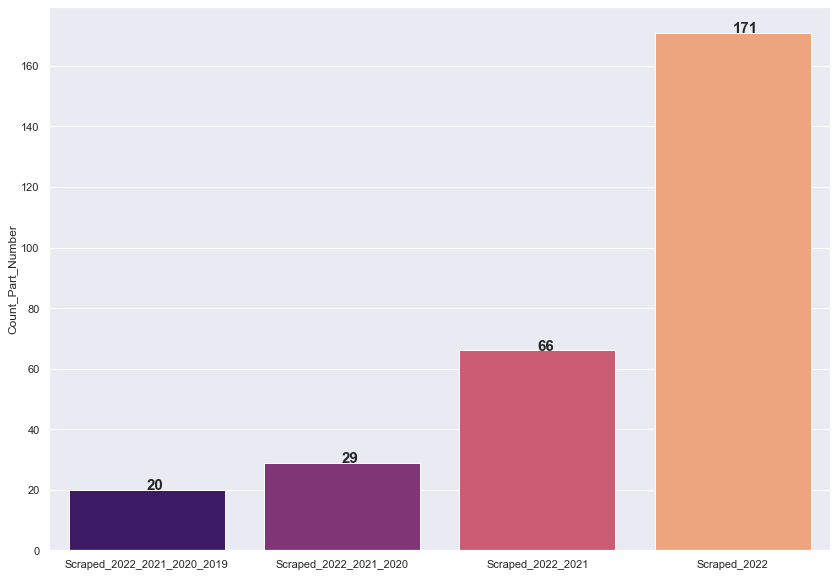

In [54]:
sns.set_theme('notebook')
plt.figure(1, figsize = (14,10))
sns.barplot(x = t.index, y = t.Count_Part_Number, data = t, palette = 'magma')
for i in range(len(t.Count_Part_Number)):
    plt.annotate(t.Count_Part_Number.values[i], (i,t.Count_Part_Number.values[i]), weight = 'bold', fontsize = 15)
plt.savefig('scraped.png')

In [55]:
df[df['Part Number'] == 75812]

,Reject Notice,Part Number,Qty,Unit Price
date,,,,


In [56]:
weights = {'2019':20,
          '2020':50,
          '2021': 70,
          '2022': 150,
          '2022_2021':200,
          '2022_2021_2020':400,
          '2022_2021_2020_2019':500}

df_counts['score'] = df_counts.apply(lambda x:  (weights['2019'] *x.scraped_2019 +
                                                weights['2020'] *x.scraped_2020 +
                                                weights['2021'] *x.scraped_2021 +
                                                weights['2022_2021'] *x.scraped_2022_2021 +
                                                weights['2022_2021_2020'] *x.scraped_2022_2021_2020 +
                                                weights['2022_2021_2020_2019'] * x.scraped_2022_2021_2020_2019), axis = 1)

df_counts['score'] = df_counts.apply(lambda x: x.score if x.scraped_2022_2021 == True else 0, axis = 1)



In [57]:
df_counts[df_counts.score > 0]

,scraped_2022,scraped_2021,scraped_2020,scraped_2019,scraped_2022_2021,scraped_2022_2021_2020,scraped_2022_2021_2020_2019,No_scraped_last_2_years,score
Part Number,,,,,,,,,
1016391-21,True,True,False,False,True,False,False,False,270
1023031-1,True,True,True,True,True,True,True,False,1240
1026189-9,True,True,False,False,True,False,False,False,270
1046779-4,True,True,False,True,True,False,False,False,290
1052168-52,True,True,True,False,True,True,False,False,720
...,...,...,...,...,...,...,...,...,...
907777C1,True,True,False,False,True,False,False,False,270
911687C3,True,True,True,False,True,True,False,False,720
948282C1,True,True,True,True,True,True,True,False,1240


In [58]:
final = df_counts.merge(df_last_date, left_index = True, right_index = True)[['scraped_2022', 'scraped_2021', 'scraped_2020', 'scraped_2019',
       'scraped_2022_2021', 'scraped_2022_2021_2020',
       'scraped_2022_2021_2020_2019', 'No_scraped_last_2_years', 'score','diff_years']].copy()

In [74]:
df2 = pd.DataFrame()
df2 = df.groupby('Part Number').agg({'Qty':'sum', 'Unit Price':'mean'})



In [75]:
final['Qty'] = df2['Qty']
final['Unit Price'] = df2['Unit Price']

In [79]:
final['has_score'] = (final['score'] > 0)

In [86]:
final['total_cost'] = final['Unit Price'] * final['Qty']
final['weighted_score'] = final['score'] * final['total_cost'] *.001

In [85]:
final.to_csv(r'C:\Users\xelin\OneDrive\Desktop\Graduate School\3rd trimester\capstone\scrap\challenge_3v1.csv')